In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-06-23 13:24:43 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'


/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-06-23 13:24:43 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100-SXM4-80GB'
2025-06-23 13:24:43 __main__ INFO     transformers.__version__='4.51.3'


In [3]:
from src.utils.training_utils import get_device_map
# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-06-23 13:24:45 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-06-23 13:24:45 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-06-23 13:24:45 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-06-23 13:24:45 wandb.docker.auth DEBUG    No config file found


## Load the LM and Fuse the $\Delta$ update

In [4]:
# os.environ["BNB_CUDA_VERSION"] = "124"
# ! echo $BNB_CUDA_VERSION
# ! python -m bitsandbytes

In [5]:
from src.models import ModelandTokenizer
from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-06-23 13:24:46 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-06-23 13:24:46 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-06-23 13:24:46 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-06-23 13:24:46 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Loading checkpoint shards: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s]

2025-06-23 13:25:11 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0


2025-06-23 13:25:11 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
from src.functional import free_gpu_cache

# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "test_72"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    f"{SYNTH_DATASET}",
    "_full__clamp=0.001", 
    model_key.split("/")[-1]
)

version = "epoch_1"
# version = "final_model"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version
)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")
# loaded_deltas

free_gpu_cache()


d = loaded_deltas['model<>layers<>10<>mlp<>gate_proj']
d.abs().max()

['trainable_params.pt']


tensor(0.0010, dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [7]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

#################################################
Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
#################################################

Trainable_CLS.fuse_with_model(mt._model, loaded_deltas)

2025-06-23 13:25:22 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-23 13:25:22 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-23 13:25:22 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-06-23 13:25:22 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-23 13:25:22 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-23 13:25:22 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-06-23 13:25:22 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
202

## Loading the Analysis Samples

In [8]:
# ----------------------------------------------------------
target_attribute = "profession"
# target_attribute = "nationality"

METRIC = "logit"
# ----------------------------------------------------------


from src.dataset import ActivationPatchingSamples

activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET, target_attribute
)
samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

for idx, sample in enumerate(samples):
    print(f"{idx} => {sample}")

0 => Sophie Evans | James Mitchell => " University" | <-- | Mohammad Aziz => " Lawyer"
1 => Mohammad Aziz | Fatima Sheikh => " Pakistani" | <-- | Sophie Evans => " Lawyer"
2 => Ali Rezaei | Zahra Hosseini => " Iranian" | <-- | João Silva => " Phys"
3 => Rahman Ali | Nasreen Begum => " Bangladesh" | <-- | Takeshi Yamamoto => " Civil"
4 => Anna Schmidt | Hans Mueller => " German" | <-- | Yuki Tanaka => " Marketing"
5 => Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
6 => Ayse Kaya | Mehmet Yilmaz => " Turkish" | <-- | Hans Mueller => " Economist"
7 => Priya Patel | Rajesh Kumar => " Indian" | <-- | Sofia Hernandez => " Graphic"
8 => Sofia Hernandez | Carlos Rodriguez => " Mexican" | <-- | Priya Patel => " Graphic"
9 => Siriporn Suwannarat | Somchai Jaidee => " Thai" | <-- | Marie Laurent => " Nutrition"
10 => Marie Laurent | Pierre Dubois => " French" | <-- | Siriporn Suwannarat => " Nutrition"
11 => Zahra Hosseini | Ali Rezaei => " Iranian" | <-- | Ah

In [9]:
nat_and_prof = [
    {"entity_pair": ["William Shakespeare", "Christopher Marlowe"], "desc": "both William Shakespeare and Christopher Marlowe are playwrights and English"},
    {"entity_pair": ["Leonardo da Vinci", "Michelangelo"], "desc": "both Leonardo da Vinci and Michelangelo are artists and Italian"},
    {"entity_pair": ["Marie Curie", "Pierre Curie"], "desc": "both Marie Curie and Pierre Curie are physicists and French"},
    {"entity_pair": ["Mark Twain", "Ernest Hemingway"], "desc": "both Mark Twain and Ernest Hemingway are writers and American"},
    {"entity_pair": ["Albert Einstein", "Werner Heisenberg"], "desc": "both Albert Einstein and Werner Heisenberg are physicists and German"},
    {"entity_pair": ["Charlie Chaplin", "Buster Keaton"], "desc": "both Charlie Chaplin and Buster Keaton are actors and British"},
    {"entity_pair": ["Frida Kahlo", "Diego Rivera"], "desc": "both Frida Kahlo and Diego Rivera are painters and Mexican"},
    {"entity_pair": ["Akira Kurosawa", "Yasujiro Ozu"], "desc": "both Akira Kurosawa and Yasujiro Ozu are film directors and Japanese"},
    {"entity_pair": ["Victor Hugo", "Alexandre Dumas"], "desc": "both Victor Hugo and Alexandre Dumas are writers and French"},
    {"entity_pair": ["Confucius", "Lao Tzu"], "desc": "both Confucius and Lao Tzu are philosophers and Chinese"},
    {"entity_pair": ["Beethoven", "Bach"], "desc": "both Beethoven and Bach are composers and German"},
    {"entity_pair": ["Plato", "Aristotle"], "desc": "both Plato and Aristotle are philosophers and Greek"},
    {"entity_pair": ["Charles Darwin", "Isaac Newton"], "desc": "both Charles Darwin and Isaac Newton are scientists and British"},
    {"entity_pair": ["Rabindranath Tagore", "Satyajit Ray"], "desc": "both Rabindranath Tagore and Satyajit Ray are artists and Indian"},
    {"entity_pair": ["Voltaire", "Rousseau"], "desc": "both Voltaire and Rousseau are philosophers and French"},
    {"entity_pair": ["Galileo Galilei", "Enrico Fermi"], "desc": "both Galileo Galilei and Enrico Fermi are physicists and Italian"},
    {"entity_pair": ["Anton Chekhov", "Leo Tolstoy"], "desc": "both Anton Chekhov and Leo Tolstoy are writers and Russian"},
    {"entity_pair": ["Pablo Picasso", "Salvador Dalí"], "desc": "both Pablo Picasso and Salvador Dalí are painters and Spanish"},
    {"entity_pair": ["Thomas Edison", "Benjamin Franklin"], "desc": "both Thomas Edison and Benjamin Franklin are inventors and American"},
    {"entity_pair": ["Coco Chanel", "Christian Dior"], "desc": "both Coco Chanel and Christian Dior are fashion designers and French"}
]

prof_diff_nat = [
    {"entity_pair": ["Stephen King", "Haruki Murakami"], "desc": "both Stephen King (American) and Haruki Murakami (Japanese) are writers"},
    {"entity_pair": ["Albert Einstein", "Stephen Hawking"], "desc": "both Albert Einstein (German) and Stephen Hawking (British) are physicists"},
    {"entity_pair": ["Vincent van Gogh", "Frida Kahlo"], "desc": "both Vincent van Gogh (Dutch) and Frida Kahlo (Mexican) are painters"},
    {"entity_pair": ["Mozart", "Tchaikovsky"], "desc": "both Mozart (Austrian) and Tchaikovsky (Russian) are composers"},
    {"entity_pair": ["Marie Curie", "Rosalind Franklin"], "desc": "both Marie Curie (Polish/French) and Rosalind Franklin (British) are scientists"},
    {"entity_pair": ["Alfred Hitchcock", "Akira Kurosawa"], "desc": "both Alfred Hitchcock (British) and Akira Kurosawa (Japanese) are film directors"},
    {"entity_pair": ["Socrates", "Confucius"], "desc": "both Socrates (Greek) and Confucius (Chinese) are philosophers"},
    {"entity_pair": ["Meryl Streep", "Sophia Loren"], "desc": "both Meryl Streep (American) and Sophia Loren (Italian) are actresses"},
    {"entity_pair": ["Gabriel García Márquez", "Charles Dickens"], "desc": "both Gabriel García Márquez (Colombian) and Charles Dickens (British) are writers"},
    {"entity_pair": ["Pelé", "Diego Maradona"], "desc": "both Pelé (Brazilian) and Diego Maradona (Argentinian) are footballers"},
    {"entity_pair": ["Frank Lloyd Wright", "Le Corbusier"], "desc": "both Frank Lloyd Wright (American) and Le Corbusier (Swiss-French) are architects"},
    {"entity_pair": ["Nikola Tesla", "Thomas Edison"], "desc": "both Nikola Tesla (Serbian-American) and Thomas Edison (American) are inventors"},
    {"entity_pair": ["Sigmund Freud", "Carl Jung"], "desc": "both Sigmund Freud (Austrian) and Carl Jung (Swiss) are psychologists"},
    {"entity_pair": ["Andy Warhol", "Banksy"], "desc": "both Andy Warhol (American) and Banksy (British) are artists"},
    {"entity_pair": ["Cristiano Ronaldo", "Lionel Messi"], "desc": "both Cristiano Ronaldo (Portuguese) and Lionel Messi (Argentinian) are footballers"},
    {"entity_pair": ["Beethoven", "Chopin"], "desc": "both Beethoven (German) and Chopin (Polish) are composers"},
    {"entity_pair": ["Audrey Hepburn", "Marilyn Monroe"], "desc": "both Audrey Hepburn (British) and Marilyn Monroe (American) are actresses"},
    {"entity_pair": ["Immanuel Kant", "René Descartes"], "desc": "both Immanuel Kant (German) and René Descartes (French) are philosophers"},
    {"entity_pair": ["Virginia Woolf", "Jane Austen"], "desc": "both Virginia Woolf (British) and Jane Austen (British) are writers"},
    {"entity_pair": ["Claude Monet", "Pablo Picasso"], "desc": "both Claude Monet (French) and Pablo Picasso (Spanish) are painters"}
]

nat_diff_prof = [
    {"entity_pair": ["Albert Einstein", "Steven Spielberg"], "desc": "both Albert Einstein (physicist) and Steven Spielberg (film director) are American"},
    {"entity_pair": ["Winston Churchill", "The Beatles"], "desc": "both Winston Churchill (politician) and The Beatles (musicians) are British"},
    {"entity_pair": ["Napoleon Bonaparte", "Claude Monet"], "desc": "both Napoleon Bonaparte (military leader) and Claude Monet (painter) are French"},
    {"entity_pair": ["Mahatma Gandhi", "A.R. Rahman"], "desc": "both Mahatma Gandhi (political leader) and A.R. Rahman (composer) are Indian"},
    {"entity_pair": ["Vladimir Putin", "Fyodor Dostoevsky"], "desc": "both Vladimir Putin (politician) and Fyodor Dostoevsky (writer) are Russian"},
    {"entity_pair": ["Bruce Lee", "Jackie Chan"], "desc": "both Bruce Lee (martial artist) and Jackie Chan (actor) are Chinese"},
    {"entity_pair": ["Pelé", "Paulo Coelho"], "desc": "both Pelé (footballer) and Paulo Coelho (writer) are Brazilian"},
    {"entity_pair": ["Angela Merkel", "Karl Lagerfeld"], "desc": "both Angela Merkel (politician) and Karl Lagerfeld (fashion designer) are German"},
    {"entity_pair": ["Hirohito", "Hayao Miyazaki"], "desc": "both Hirohito (emperor) and Hayao Miyazaki (animator) are Japanese"},
    {"entity_pair": ["Eva Perón", "Jorge Luis Borges"], "desc": "both Eva Perón (political figure) and Jorge Luis Borges (writer) are Argentinian"},
    {"entity_pair": ["Cleopatra", "Mohamed Salah"], "desc": "both Cleopatra (queen) and Mohamed Salah (footballer) are Egyptian"},
    {"entity_pair": ["Socrates", "Maria Callas"], "desc": "both Socrates (philosopher) and Maria Callas (opera singer) are Greek"},
    {"entity_pair": ["Julius Caesar", "Federico Fellini"], "desc": "both Julius Caesar (military leader) and Federico Fellini (film director) are Italian"},
    {"entity_pair": ["Queen Elizabeth II", "Stephen Hawking"], "desc": "both Queen Elizabeth II (monarch) and Stephen Hawking (physicist) are British"},
    {"entity_pair": ["Abraham Lincoln", "Michael Jordan"], "desc": "both Abraham Lincoln (president) and Michael Jordan (basketball player) are American"},
    {"entity_pair": ["Charles de Gaulle", "Coco Chanel"], "desc": "both Charles de Gaulle (president) and Coco Chanel (fashion designer) are French"},
    {"entity_pair": ["Mao Zedong", "Yao Ming"], "desc": "both Mao Zedong (political leader) and Yao Ming (basketball player) are Chinese"},
    {"entity_pair": ["Nelson Mandela", "Charlize Theron"], "desc": "both Nelson Mandela (political leader) and Charlize Theron (actress) are South African"},
    {"entity_pair": ["Simón Bolívar", "Shakira"], "desc": "both Simón Bolívar (military leader) and Shakira (singer) are Colombian"},
    {"entity_pair": ["King Juan Carlos I", "Rafael Nadal"], "desc": "both King Juan Carlos I (monarch) and Rafael Nadal (tennis player) are Spanish"}
]

In [10]:
from src.probing.prompt import BiAssociationPrefix
from src.utils.experiment_utils import set_seed

prefix_generator_cls = BiAssociationPrefix

prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=[ 
        "profession", 
        "nationality",
        "school"
    ],
    format="_3",
)

set_seed(142)
prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

2025-06-23 13:25:24 src.utils.experiment_utils INFO     setting all seeds to 142
# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same profession → "Yes - [profession] - they are both [profession]"
2. Same nationality → "Yes - [nationality] - they are both [nationality]"
3. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

## Your turn, give y

In [66]:
from src.probing.prompt import prepare_probing_input
from src.functional import predict_next_token
from src.utils.typing import TokenizerOutput

# query_entities = ["Mads Mikkelsen", "Nikolaj Coster-Waldau"]
# query_entities = ["Sachin Tendulkar", "Rahul Dravid"]
query_entities = ["Taylor Swift", "Bill Gates"]
# query_entities = ["Issac Newton", "Charles Darwin"]
# query_entities = ["Jon Stewart", "Rowan Atkinson"]
# query_entities = ("John F. Kennedy", "Michael Jordan")
# query_entities = ["Elton John", "John Lennon"]
# query_entities = ["David Bowie", "Elvis Presley"]
# query_entities = ["Christiano Ronaldo", "Rowan Atkinson"]
# query_entities = ["Jack Ma", "Hayao Miyazaki"]
# query_entities = ["Claude Monet", "Leonardo da Vinci"]
# query_entities = ["Claude Monet", "Zinedine Zidane"]
# query_entities = ["Zinedine Zidane", "Claude Monet"]
# query_entities = ["Zinedine Zidane", "Thierry Henry"]
# query_entities = ["Richard Feynman", "J. Robert Oppenheimer"]
# query_entities = ["Victor Hugo", "Alexandre Dumas"]
# query_entities = ["Charles Darwin", "Isaac Newton"]
# query_entities = ["Alfred Hitchcock", "Akira Kurosawa"]
# query_entities = ["Beethoven", "Chopin"]
# query_entities = ["William Shakespeare", "Christopher Marlowe"]
# query_entities = ["Antonio Vivaldi", "Chopin"]
# query_entities = ["Masayoshi Son", "Jack Ma"]
# query_entities = ["John F. Kennedy", "Indira Gandhi"]
# query_entities = ["Michael Jordan", "Sachin Tendulkar"]

# query_entities = ["Pelé", "Paulo Coelho"]
# query_entities = ["Abraham Lincoln", "Michael Jordan"]
# query_entities = ["Christiano Ronaldo", "Sachin Tendulkar"]
# query_entities = ["Thomas Edison", "Benjamin Franklin"]
# query_entities = ["Coco Chanel", "Christian Dior"]

probing_input = prepare_probing_input(
    mt=mt,
    entities=query_entities,
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -",
)

next_probs = predict_next_token(
    mt=mt,
    inputs=TokenizerOutput(data=probing_input.tokenized),
    k=10
)

print(f'{query_entities} | => {next_probs[0]}')

next_probs

['Taylor Swift', 'Bill Gates'] | => [PredictedToken(token=' American', prob=0.419921875, logit=17.625, token_id=3778, metadata=None), PredictedToken(token=' University', prob=0.369140625, logit=17.5, token_id=3907, metadata=None), PredictedToken(token=' New', prob=0.03662109375, logit=15.1875, token_id=1561, metadata=None), PredictedToken(token=' Boston', prob=0.022216796875, logit=14.6875, token_id=10406, metadata=None), PredictedToken(token=' United', prob=0.01263427734375, logit=14.125, token_id=3723, metadata=None), PredictedToken(token=' Harvard', prob=0.01263427734375, logit=14.125, token_id=25996, metadata=None), PredictedToken(token=' America', prob=0.01116943359375, logit=14.0, token_id=5270, metadata=None), PredictedToken(token=' Stanford', prob=0.01116943359375, logit=14.0, token_id=31788, metadata=None), PredictedToken(token=' Brown', prob=0.01116943359375, logit=14.0, token_id=10690, metadata=None), PredictedToken(token=' Singer', prob=0.00982666015625, logit=13.875, token

[[PredictedToken(token=' American', prob=0.419921875, logit=17.625, token_id=3778, metadata=None),
  PredictedToken(token=' University', prob=0.369140625, logit=17.5, token_id=3907, metadata=None),
  PredictedToken(token=' New', prob=0.03662109375, logit=15.1875, token_id=1561, metadata=None),
  PredictedToken(token=' Boston', prob=0.022216796875, logit=14.6875, token_id=10406, metadata=None),
  PredictedToken(token=' United', prob=0.01263427734375, logit=14.125, token_id=3723, metadata=None),
  PredictedToken(token=' Harvard', prob=0.01263427734375, logit=14.125, token_id=25996, metadata=None),
  PredictedToken(token=' America', prob=0.01116943359375, logit=14.0, token_id=5270, metadata=None),
  PredictedToken(token=' Stanford', prob=0.01116943359375, logit=14.0, token_id=31788, metadata=None),
  PredictedToken(token=' Brown', prob=0.01116943359375, logit=14.0, token_id=10690, metadata=None),
  PredictedToken(token=' Singer', prob=0.00982666015625, logit=13.875, token_id=55770, metada

In [67]:
from src.functional import get_hs
import itertools

resid_layers = mt.layer_names
token_positions = (
    list(range(*probing_input.entity_ranges[0]))
    + list(range(*probing_input.entity_ranges[1]))
    + [-1]
)
locations = list(itertools.product(resid_layers, token_positions))

hs = get_hs(
    mt=mt,
    input=TokenizerOutput(data=probing_input.tokenized),
    locations=locations,
)

In [68]:
from src.operators.operators import BasisOperator, Basis
import baukit

countries = [
    "United States",
    "Canada",
    "Mexico",
    "Brazil",
    "Argentina",
    "England",
    "France",
    "Germany",
    "Spain",
    "Italy",
    "Russia",
    "China",
    "Japan",
    "India",
    "Australia",
    "South Korea",
    "Indonesia",
    "Thailand",
    "Vietnam",
    "Philippines",
    "Egypt",
    "South Africa",
    "Nigeria",
    "Kenya",
    "Morocco",
    "Saudi Arabia",
    "Emirates",
    "Israel",
    "Turkey",
    "Greece",
    "Poland",
    "Ukraine",
    "Sweden",
    "Norway",
    "Finland",
    "Denmark",
    "Netherlands",
    "Belgium",
    "Switzerland",
    "Austria",
    "Portugal",
    "Ireland",
    "New Zealand",
    "Singapore",
    "Malaysia",
    "Pakistan",
    "Bangladesh",
    "Chile",
    "Peru",
    "Colombia"
]
professions = [
    "Doctor",
    "Engineer",
    "Teacher",
    "Lawyer",
    "Nurse",
    "Architect",
    "Accountant",
    "Scientist",
    "Artist",
    "Writer",
    "Musician",
    "Actor",
    "Chef",
    "Photographer",
    "Journalist",
    "Police Officer",
    "Firefighter",
    "Pilot",
    "Software Developer",
    "Dentist",
    "Psychologist",
    "Veterinarian",
    "Pharmacist",
    "Designer",
    "Entrepreneur",
    "Consultant",
    "Banker",
    "Real Estate Agent",
    "Marketing Manager",
    "Data Analyst",
    "Electrician",
    "Plumber",
    "Mechanic",
    "Carpenter",
    "Surgeon",
    "Professor",
    "Social Worker",
    "Therapist",
    "Translator",
    "Film Director",
    "Athlete",
    "Coach",
    "Librarian",
    "Flight Attendant",
    "Barista",
    "Hairdresser",
    "Fashion Designer",
    "Interior Designer",
    "Judge",
    "Paramedic",
    "Composer"
]

professions += ["Footballer", "Writer", "President", "Lawer", "Athlete", "Basketball"]
professions = set(professions)  # remove duplicates
professions = [p.lower() for p in professions]

concept_zs = [f" {z}" for z in professions]
# concept_zs = [f" {z}" for z in countries]

z_tokens = [mt.tokenizer.encode(c, add_special_tokens=False)[0] for c in concept_zs]
lm_head = baukit.get_module(mt._model, "lm_head")

basis_directions: list[Basis] = []

for z_tok in z_tokens:
    direction = lm_head.weight[z_tok]
    direction = direction / direction.norm()
    basis_directions.append(
        Basis(
            direction = direction,
            z = mt.tokenizer.decode(z_tok),
            token_idx = z_tok,
        )
    )

basis_operator = BasisOperator(
    mt = mt,
    concept_directions= basis_directions,
)

In [71]:
token_idx = probing_input.entity_ranges[0][1] - 1
# token_idx = probing_input.entity_ranges[1][1] - 1
# token_idx = -1
layer_idx = 5

basis_operator(
    h = hs[(mt.layer_name_format.format(layer_idx), token_idx)],
    project_to_subspace=True
)

2025-06-23 17:27:31 src.operators.operators DEBUG    h.device=device(type='cuda', index=0), self.projection_matrix.device=device(type='cuda', index=0)


[{'sim': 0.239362895488739, 'basis': '" writer" (7061)'},
 {'sim': 0.2276141494512558, 'basis': '" software" (3241)'},
 {'sim': 0.20870478451251984, 'basis': '" photographer" (29867)'},
 {'sim': 0.19410379230976105, 'basis': '" lawyer" (15779)'},
 {'sim': 0.19162431359291077, 'basis': '" architect" (11726)'},
 {'sim': 0.1355878710746765, 'basis': '" composer" (40550)'},
 {'sim': 0.1320614516735077, 'basis': '" banker" (72759)'},
 {'sim': 0.1302892565727234, 'basis': '" veterinarian" (82340)'},
 {'sim': 0.12028700113296509, 'basis': '" fashion" (11401)'},
 {'sim': 0.11770419776439667, 'basis': '" marketing" (8661)'},
 {'sim': 0.103007972240448, 'basis': '" mechanic" (45239)'},
 {'sim': 0.09937651455402374, 'basis': '" translator" (46588)'},
 {'sim': 0.09749685227870941, 'basis': '" chef" (30806)'},
 {'sim': 0.08735021948814392, 'basis': '" football" (9141)'},
 {'sim': 0.07163520157337189, 'basis': '" flight" (11213)'},
 {'sim': 0.07097339630126953, 'basis': '" carp" (39739)'},
 {'sim': 

In [72]:
from src.functional import logit_lens

h_proj = basis_operator.project_to_subspace(h = hs[(mt.layer_name_format.format(layer_idx), token_idx)])
logit_lens(
    mt = mt, 
    h = h_proj.to(mt.dtype).to(mt.device),
    k=15
)

[PredictedToken(token=' software', prob=0.0888671875, logit=9.875, token_id=3241, metadata=None),
 PredictedToken(token=' writer', prob=0.078125, logit=9.75, token_id=7061, metadata=None),
 PredictedToken(token=' architect', prob=0.0238037109375, logit=8.5625, token_id=11726, metadata=None),
 PredictedToken(token=' lawyer', prob=0.01318359375, logit=7.96875, token_id=15779, metadata=None),
 PredictedToken(token=' Software', prob=0.01202392578125, logit=7.875, token_id=4476, metadata=None),
 PredictedToken(token='software', prob=0.00994873046875, logit=7.6875, token_id=37751, metadata=None),
 PredictedToken(token=' Lawyer', prob=0.0096435546875, logit=7.65625, token_id=71314, metadata=None),
 PredictedToken(token=' photographer', prob=0.0096435546875, logit=7.65625, token_id=29867, metadata=None),
 PredictedToken(token='Software', prob=0.00604248046875, logit=7.1875, token_id=19805, metadata=None),
 PredictedToken(token=' Writer', prob=0.00531005859375, logit=7.0625, token_id=30504, met

In [73]:
# context = """
# <Name of a famous person> <their profession>
# Hugh Jackman actor
# Michael Jackson singer
# Barack Obama politician
# Elon Musk entrepreneur
# placeholder"""

context = """Name of a famous person -> their profession
Hugh Jackman -> actor
Michael Jackson -> singer
Barack Obama -> politician
Elon Musk -> entrepreneur
placeholder ->"""

# context = """
# Name of a famous person -> their nationality
# Hugh Jackman -> Australian
# Michael Jackson -> American
# Marie Curie -> Polish
# Imran Khan -> Pakistani
# placeholder ->"""

In [75]:
from src.tokens import prepare_input, find_token_range

# subj = "Albert Einstein"
# subj = "Sachin Tendulkar"
subj = query_entities[1]
context_subj = context.replace("placeholder", subj)

subj_inputs = prepare_input(prompts=context_subj, tokenizer=mt, return_offsets_mapping=True)
offset_mapping = subj_inputs.pop("offset_mapping")[0]

subj_range = find_token_range(
    string = context_subj,
    substring = subj,
    tokenizer=mt.tokenizer,
    offset_mapping=offset_mapping,   
)

locations = [
    (mt.layer_name_format.format(l), subj_range[1] - 1)
    for l in range(mt.n_layer)
] 

locations += [(mt.layer_names[-1], -1)]

subj_hs = get_hs(
    mt = mt,
    input=subj_inputs,
    locations=locations,
    return_dict=True
)

ps_pred = logit_lens(
    mt = mt, 
    h = subj_hs[(mt.layer_names[-1], -1)],
    k=15
)

print(ps_pred[0])

ps_pred

" entrepreneur"[29349] (p=0.648, logit=22.750)


[PredictedToken(token=' entrepreneur', prob=0.6484375, logit=22.75, token_id=29349, metadata=None),
 PredictedToken(token=' businessman', prob=0.1279296875, logit=21.125, token_id=47378, metadata=None),
 PredictedToken(token=' programmer', prob=0.087890625, logit=20.75, token_id=48888, metadata=None),
 PredictedToken(token=' business', prob=0.04150390625, logit=20.0, token_id=2626, metadata=None),
 PredictedToken(token=' software', prob=0.032470703125, logit=19.75, token_id=3241, metadata=None),
 PredictedToken(token=' computer', prob=0.032470703125, logit=19.75, token_id=6500, metadata=None),
 PredictedToken(token=' philanth', prob=0.01531982421875, logit=19.0, token_id=58738, metadata=None),
 PredictedToken(token=' entre', prob=0.0009765625, logit=16.25, token_id=9465, metadata=None),
 PredictedToken(token=' techn', prob=0.00086212158203125, logit=16.125, token_id=2869, metadata=None),
 PredictedToken(token=' investor', prob=0.000713348388671875, logit=15.9375, token_id=30693, metada

In [92]:
track_toks = []

for entity in query_entities:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt = mt, inputs = context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)

track_toks = [p.token_id for p in track_toks]
track_toks = list(set(track_toks))  # remove duplicates
[mt.tokenizer.decode(t) for t in track_toks]

Taylor Swift => " singer"[23597] (p=0.973, logit=25.875)
Bill Gates => " entrepreneur"[29349] (p=0.648, logit=22.750)


[' singer', ' entrepreneur']

In [93]:
from src.functional import patchscope

token_idx = probing_input.entity_ranges[0][1] - 1
# token_idx = probing_input.entity_ranges[1][1] - 1
# token_idx = -1
layer_idx = 7
# patch_layers = [5]
patch_layers = list(range(5, 16))

patchscope(
    mt = mt,
    h = hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
    patchscope_context= context,
    placeholder = "placeholder",
    patch_layers = [mt.layer_name_format.format(l) for l in patch_layers],
    k = 15
)

2025-06-23 17:36:25 src.functional DEBUG    placeholder position: 33 | token: "placeholder"


[PredictedToken(token=' singer', prob=0.984375, logit=23.375, token_id=23597, metadata=None),
 PredictedToken(token=' musician', prob=0.01092529296875, logit=18.875, token_id=39844, metadata=None),
 PredictedToken(token=' Singer', prob=0.00130462646484375, logit=16.75, token_id=55770, metadata=None),
 PredictedToken(token=' songwriter', prob=0.000579833984375, logit=15.9375, token_id=85757, metadata=None),
 PredictedToken(token=' pop', prob=0.0003509521484375, logit=15.4375, token_id=2477, metadata=None),
 PredictedToken(token=' actress', prob=0.0002269744873046875, logit=15.0, token_id=24577, metadata=None),
 PredictedToken(token=' music', prob=0.0002002716064453125, logit=14.875, token_id=4731, metadata=None),
 PredictedToken(token=' ', prob=0.0002002716064453125, logit=14.875, token_id=220, metadata=None),
 PredictedToken(token=' (', prob=0.00012159347534179688, logit=14.375, token_id=320, metadata=None),
 PredictedToken(token=' artist', prob=0.00011396408081054688, logit=14.3125, t

In [94]:
from src.operators.utils import patch as patch_check
from src.operators.utils import module_output_has_extra_dim

context_tok = prepare_input(
    prompts=context,
    tokenizer=mt,
    return_offsets_mapping=True
)

offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = find_token_range(
    string=context,
    substring="placeholder",
    offset_mapping=offset_mapping,
    tokenizer=mt.tokenizer,
    occurrence=-1
)[1] - 1

###########################################################################
layer_indices = list(range(mt.n_layer))
# layer_indices = [5, 15, 25, 35, 45]

token_ranges = {
    "last_tok": [-1],
    probing_input.entities[0]: list(range(*probing_input.entity_ranges[0])),
    probing_input.entities[1]: list(range(*probing_input.entity_ranges[1])),
}
###########################################################################

inputs = TokenizerOutput(data=probing_input.tokenized)
print(f"[\"{[mt.tokenizer.decode(t) for t in track_toks]}\"]")

score_track = {k: {} for k in token_ranges.keys()}

for layer_idx in layer_indices:
    print(f"layer_idx={layer_idx} ({mt.layer_name_format.format(layer_idx)})")
    for key, token_range in token_ranges.items():
        print(
            f'"{key}" {token_range} => "{mt.tokenizer.decode(inputs.input_ids[0][token_range], skip_special_tokens=False)}"'
        )
        for token_idx in token_range:
            z = patch_check(
                mt=mt,
                h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
                inp_layer=mt.layer_name_format.format(5),
                out_layer=mt.layer_names[-1],
                context=context_tok,
                h_idx=h_idx,
            )

            ll_pred, ll_track = logit_lens(mt=mt, h=z, k=15, interested_tokens=track_toks)
            ll_fmt = [
                f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]' for pred in ll_pred
            ]
            if token_idx not in score_track[key]:
                score_track[key][token_idx] = []
            score_track[key][token_idx].append((ll_pred, ll_track))
            print(f'{token_idx=} ["{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}"] => {ll_fmt[:5]}')

        print()
    
    print("-" * 50)

["[' singer', ' entrepreneur']"]
layer_idx=0 (model.layers.0)
"last_tok" [-1] => " -"
token_idx=-1 [" -"] => ['"?\n"[p=0.31, l=14.88]', '"?\n\n"[p=0.18, l=14.31]', '"?"[p=0.08, l=13.56]', '" -\n"[p=0.04, l=12.81]', '"??"[p=0.03, l=12.50]']

"Taylor Swift" [245, 246] => " Taylor Swift"
token_idx=245 [" Taylor"] => ['" singer"[p=0.26, l=14.44]', '"?"[p=0.07, l=13.06]', '"?\n"[p=0.06, l=13.00]', '" unknown"[p=0.05, l=12.75]', '" model"[p=0.04, l=12.56]']
token_idx=246 [" Swift"] => ['" singer"[p=0.88, l=18.25]', '" musician"[p=0.02, l=14.31]', '"?\n"[p=0.01, l=14.00]', '" Taylor"[p=0.01, l=13.75]', '"?"[p=0.01, l=13.38]']

"Bill Gates" [248, 249] => " Bill Gates"
token_idx=248 [" Bill"] => ['" Gates"[p=0.27, l=14.31]', '" politician"[p=0.12, l=13.50]', '" unknown"[p=0.04, l=12.38]', '"?"[p=0.03, l=12.25]', '"?\n"[p=0.03, l=12.06]']
token_idx=249 [" Gates"] => ['" entrepreneur"[p=0.32, l=16.00]', '" Bill"[p=0.08, l=14.56]', '" philanth"[p=0.07, l=14.44]', '" politician"[p=0.06, l=14.31]', 

In [99]:
track_tok = track_toks[1]
mt.tokenizer.decode(track_tok)

' entrepreneur'

(0.0, 1.3708385417663904)

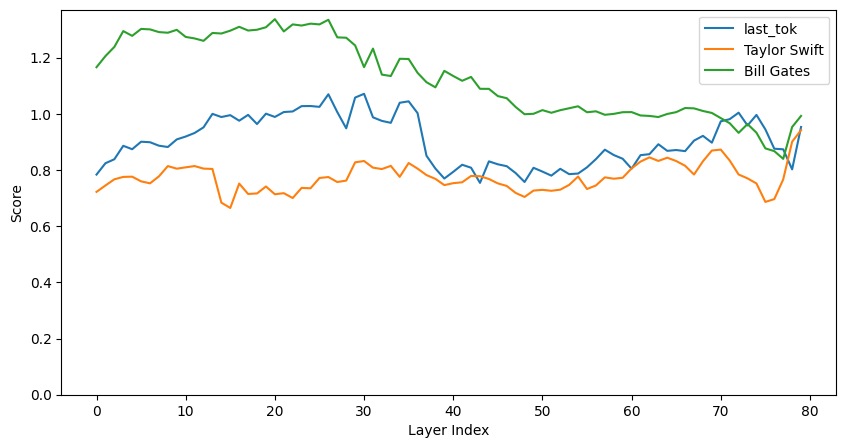

In [100]:
# METRIC = "prob"
METRIC = "logit"
from src.trace import rank_reward

category_scores = {category: [] for category in token_ranges.keys()}

for layer_idx in layer_indices:
    for key, token_range in token_ranges.items():
        cur_score = None
        for token_idx in token_range:
            ll_pred, ll_track = score_track[key][token_idx][layer_idx]
            score = getattr(ll_track[track_tok][1], METRIC)
            denom = sum([getattr(pred, METRIC) for pred in ll_pred]) / len(ll_pred)
            score = score/denom
            # rank = ll_track[track_tok][0]
            # score = rank_reward(rank, k=20)
            cur_score = score if cur_score is None else max(cur_score, score)
        category_scores[key].append(cur_score)


from matplotlib import pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
for key, scores in category_scores.items():
    # scores = np.array(scores) #/ getattr(ps_pred[0], METRIC)
    scores = np.array(scores) #/ max(scores)  # Normalize scores
    plt.plot(layer_indices, scores, label=key)

plt.legend()
plt.xlabel("Layer Index")
plt.ylabel("Score")
plt.ylim(bottom=0)